# **DICOM Metadata → CSV Dataset**
DICOM, Digital Imaging and Communications in Medicine, is the native format of medical images. DICOM files consider data beyond pixel data and store it as a DICOM header. Such data are the Patient's age and weight, Modality, Image Dimension, and so on. In this post, we will use the PyDicom package to build a Python function that can extract specific metadata to use in further data analysis work.

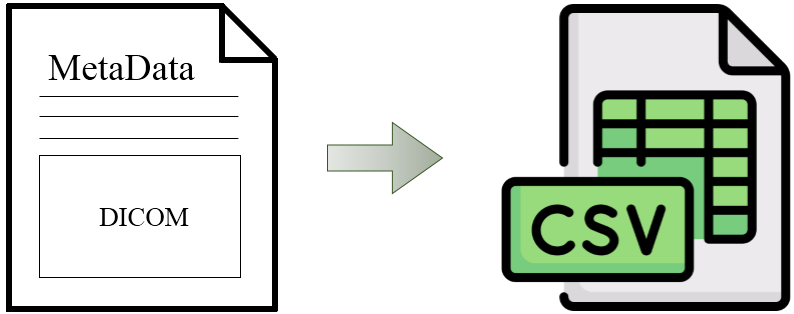

# **Background**
As mentioned above, DICOM files have metadata. This data is useful for any DICOM user, from the patient to the doctors and the modalities of the imaging systems. Furthermore, it's treasury data that Data Scientists /Analysts can use to do very helpful insights.
A good thing about this metadata is that it's represented in a standardized method where each DICOM attribute has a unique tag and keyword to give the user the information in a specific value representation.

**Let's get to code and see an example of DICOM headers…**

We will start with a simple example of reading a DICOM file to see the metadata representation. Then we'll build a function to extract the data.
There are a lot of DICOM samples on the internet. And you can use your own DICOM files. For this post, I chose a [dataset](https://www.kaggle.com/datasets/dmisky/dlwptvolumetricdicomlung) of 99 slices of chest-CT scans for one patient. You can find it on Kaggle. I saved the dataset on my [Drive](https://drive.google.com/drive/folders/1dbJpXVUBn0mSUxgJIqKZj4d_0thSeTW3?usp=sharing) so I can easily have access through GoogleColab.

In [1]:
# Install and import the package
!pip install pydicom
import pydicom

# Reading a DICOM file from a specific path
dcm_data = pydicom.dcmread('/content/drive/MyDrive/Datasets/Kaggle/DICOM/dicom_lung/000000.dcm')
dcm_data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.2 MB/s eta 0:00:00


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7085.2626.214140401149739061368142942055
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7085.2626.214140401149739061368142942055
(0008, 0020) St

**PyDicom** wraps a DataSet class and for each DICOM attribute, it starts with the tag as a key of the DataSet and the data element as a value. The image below describes the contents of the DataSet and DataElement classes.

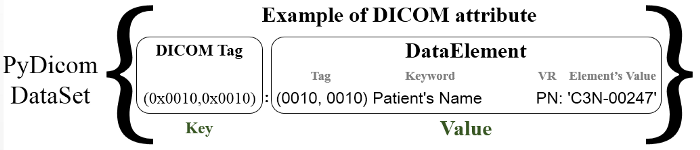

**PyDicom** package provides many methods and attributes to use with DataSet and DataElement classes. We won't dive into details about it. If you want to learn about it, refer to this previous [post](https://towardsdatascience.com/introducing-pydicom-its-classes-methods-and-attributes-518c1d71162).

# **Extract the metadata**
The main idea we will depend on is that we can iterate over the DICOM files in a specific folder. Then we will iterate over the whole attributes in each file and extract only the attributes specified in advance. We will use the keywords of DICOM attributes as it's the best choice because:
- Each DICOM attribute has its unique keyword.
- The keywords are better than tags as they are human-readable.

There are dozens of attributes that can characterize DICOM files. So, you cannot just read all of them. You need to focus only on the attributes that you might counter during your work. For this purpose, I highly recommend this great [**DICOM Standard Browser**](https://dicom.innolitics.com/ciods) which was built by Innolitics, you just need to search for the attribute you want to learn about. Make sure you type the keywords you want correctly.

**Now that we understand what we will do, let's extract some DICOM metadata:)**

We will need **glob** package to manipulate the paths of DICOM files. Also, the **Pandas** package is required to write the CSV file from a pandas data frame. The glob module finds all the path names matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

All that's left to set our python environment ready is to import the packages and build our function. Documentation of the function will be added to explain the parameters and the output of the function.

In [3]:
import pydicom
import pandas as pd
import glob

In [4]:
def dicom2csv(extract = [],
              move_on = [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)],
              folder_path = str(),
              csv_file_name = "metadata.csv",
              return_dataframe = False):
  
  '''
  Extract specific DICOM metadata from multiple DICOM files collected in a
  specified folder.

  ::Params
      - extract (list):
          The keywords of the DICOM attributes you want to extract.

      - move_on (list):
          The tags of the DICOM attributes you don't want to move on.
          By default,it contains a list of the tags of pixel data:
          [(0x7FE0,0x0008), (0x7FE0,0x0009), (0x7FE0,0x0010)]
          If you want to move on onto some attributes, it's recommended
          to append its unique tags in addition to pixel data tags.

      - folder_path (string):
          Path of the folder that contains the DICOM files.

      - csv_file_name (string):
          The name of the CSV file.

      - return_dataframe (bool):
          if True, returns a pandas dataframe of the extracted data for direct use.
  
  :: Returns
      - CSV file contains DICOM metadata specified the parameter extracted.
      - Pandas dataframe when return_dataframe is set to True.
  '''
  
  # Initialize the meta dictionary that will have the specified attributes
  meta = {keyword:[] for keyword in extract}

  # List the files' names that we want to extract data from
  dicom_files = glob.glob(folder_path+'/*.dcm')

  # Iterate over each DICOM file in the folder and read it using dcmread()
  for file_path in dicom_files:
    # Read the DICOM file from the specified path
    dcm = pydicom.dcmread(file_path)

    # Iterate over the DICOM attributes in the current DICOM file "dcm"
    for elem in dcm.iterall():
      # Ensure that the attribute is not a pixel data and it's one of the required attributes
      if (elem.tag not in move_on) and (elem.keyword in extract):
        # Append the value of the current attribute
        meta[elem.keyword].append(elem.value)
  
  # Create a pandas dataframe for better use of the data
  df = pd.DataFrame(data=meta, columns = extract)

  # Create the CSV file with the specified name
  df.to_csv(csv_file_name, index=False)

  # Return the extracted dataframe for direct use
  if return_dataframe:
    return df

Let's try the above function. First, we decide what DICOM attributes we are interested in. For example, I want to calculate the DLP index from a series of Chest CT scans. **DLP index, Dose-Length Product**, is a commonly used index that factors in the length of the scan to show overall dose output. It's commonly used and represented at the consoles of modern modalities because it gives a rough estimation of the effective dose (ED) in advance.

DLP can be calculated from CTDIvol, another CT index that describes the average dose for a single image for the selected CT conditions of operation represented in mGy. Dose–length product (DLP) is used to calculate the dose for a series of scans or a complete examination and is defined by the following equation:
$$
  DLP = \sum^N_{i=1}(CTDIvol)_i .L_i
$$
Where i is for the ith CTDIvol for each image that covers a length of Li. For Li, we will use the reconstruction interval between every two sequenced images because it is what actually determines the number of images that correspond to a given scan length. Slice Location will help us calculate the reconstruction intervals in millimeters.
So, the metadata we need to calculate DLP are **CTDIvol** represented in mGy (milli-Gray) and the **SliceLocation** of each axial slice expresses in mm. Let's use the function we've built above to extract them.

So, the metadata we need to calculate DLP are CTDIvol represented in mGy (milli-Gray) and the SliceLocation of each axial slice expresses in mm. Let's use the function we've built above to extract them.

In [5]:
# Extract the SliceLocation and CTDIvol from DICOM files of Chest-CT
df = dicom2csv(extract = ['SliceLocation', 'CTDIvol'],
          folder_path = '/content/drive/MyDrive/Datasets/Kaggle/DICOM/dicom_lung',
          csv_file_name = 'data.csv', 
          return_dataframe = True)

**Note** that reading DICOM files is done arbitrarily. So, we need to sort the data based on the slice location.

In [6]:
# Sort the data frame to get the slices in order
df.sort_values(by='SliceLocation', inplace=True, ignore_index=True)
df

,SliceLocation,CTDIvol
0,-288.0,8.550
1,-285.0,8.450
2,-282.0,8.250
3,-279.0,8.025
4,-276.0,7.850
...,...,...
94,-6.0,12.450
95,-3.0,12.325
96,0.0,12.125
97,3.0,11.925


Vividly, the reconstruction interval is 3.0 mm from the look at the "SliceLocation" column, which is the same as the slice thickness. You can try the following line code to ensure that the reconstruction interval is the same for all slices.

In [ ]:
# Calculate the reconstruction interval from SliceLocation
[df['SliceLocation'][i+1] - df['SliceLocation'][i] for i in range(0,len(df)-1)]

Back to the DLP equation, Li is the same for all slices and it's 0.3 cm. Our final touch is to multiply each CTDIvol by 0.3 and sum the variables.

In [8]:
import numpy as np
# Calculating DPL = sum(CTDIvol * 0.3)
print('DLP = ',np.sum(df['CTDIvol'].values * 0.3), 'mGy*cm')

DLP =  239.90999999999994 mGy*cm


It is important to remember that the CTDIvol or its derivative the DLP, as seen on consoles and outputted on the DICOM images, does not represent the actual absorbed or effective dose for the patient. They should be taken as an index of radiation output by the system for comparison purposes. And the calculation of Effective Dose based on DLP is just a rough estimation.

DLP calculation was just one single example of how useful extracting data from DICOM headers is. And the python function we've built makes it easy to deal with the specified metadata.

# **Conclusion**
- We've seen how to use the PyDicom package to read DICOM files. And the power of using DICOM metadata in our analyzing work.
- We've built a function that converts the specific data from DICOM headers into a CSV file to use in further insights.
- We've used the function to calculate the Dose Length Product, which is a common used parameter in dose estimation for CT modalities.

###**Thanks For Reading…**

# **Recommendation**
- ***DICOM Metadata - A Useful Resource for Big Data Analytics:***
This [**article**](https://healthmanagement.org/c/healthmanagement/issuearticle/dicom-metadata-a-useful-resource-for-big-data-analytics) provides an overview of new ways to represent data by combining patient access and DICOM information, advanced use of medical imaging metadata, analysis of radiation dose and image segmentation, and deep learning for feature engineering to enrich data.
- For more details about DICOM: refer to the previous blog, [**What is DICOM?**](https://medium.com/@omar.ok1998/what-is-dicom-a28c5fe24c9d)
- [Caculating DLP from Computed Tomography Dose Index, CTDIvol](https://howradiologyworks.com/dlp-calculator/).

# **References**
[1] PyDicom Documentation, [**User Guide**](https://pydicom.github.io/pydicom/stable/old/pydicom_user_guide.html), [Accessed at 25/12/2022]

[2] PyDicom Documentation, [**Element VRs and Python types**](https://pydicom.github.io/pydicom/stable/guides/element_value_types.html), [Accessed at 25/12/2022]

[3] PyDicom Documentation, [**API Reference**](https://pydicom.github.io/pydicom/stable/reference/index.html), [Accessed at 25/12/2022]

[4] Innolitics, DICOM Standard Browser, (2022), [**CTDIvol Attribute**](https://dicom.innolitics.com/ciods/ct-image/ct-image/00189345), [Accessed at 10/1/2023]

[5] I. A. Tsalafoutas and S. I. Metallidis, "A method for calculating the dose length product from CT DICOM images," BJR, vol. 84, no. 999, pp. 236–243, Mar. 2011, doi: 10.1259/bjr/37630380.